In [13]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [15]:
DATASET_NAME = 'cstr'

In [16]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=10, noise_scale=0.2, use_classes=list(range(0,10)))

In [17]:
# print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
print(labels['label'])

node_id     timestamp
node_1_10   0            0
node_1_100  0            1
node_1_101  0            1
node_1_102  0            1
node_1_103  0            1
                        ..
node_9_95   0            9
node_9_96   0            9
node_9_97   0            9
node_9_98   0            9
node_9_99   0            9
Name: label, Length: 990, dtype: int64


In [18]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [19]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] .......... (step 2 of 5) Processing features, total=   4.2s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [20]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


In [21]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.9350916569036519
0 0.8990825688073395
1 0.9333333333333333
2 1.0
3 0.9790209790209791
4 0.9859154929577465
5 1.0
6 0.9459459459459459
7 0.9790209790209791
8 1.0
9 0.7777777777777778


In [22]:
label_list = pipeline.steps[4][1].classes_
label_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

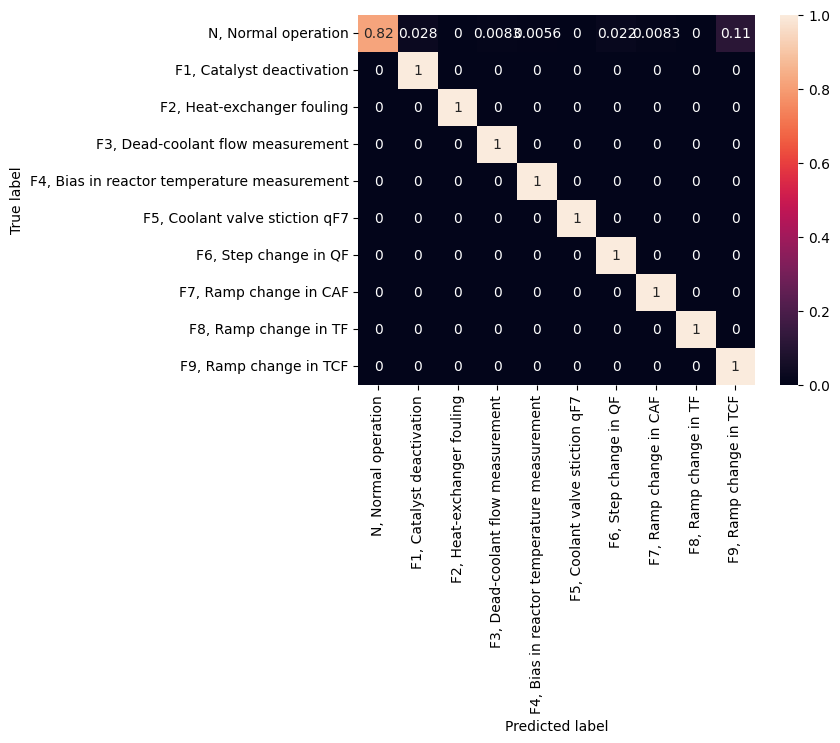

In [24]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}
# label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}

text_labels = [label_dict[str(i)] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [26]:
test_labels['label']

node_id     timestamp
node_1_10   0            0
node_1_100  0            1
node_1_101  0            1
node_1_102  0            1
node_1_103  0            1
                        ..
node_9_95   0            9
node_9_96   0            9
node_9_97   0            9
node_9_98   0            9
node_9_99   0            9
Name: label, Length: 990, dtype: int64

In [27]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 0 #UPDATE HERE FOR OTHER CLASSES
pred_select = 9 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_9_10', 880], ['node_9_11', 891], ['node_9_12', 902], ['node_9_13', 903], ['node_9_14', 904], ['node_9_15', 905], ['node_9_16', 906], ['node_9_17', 907], ['node_9_18', 908], ['node_9_19', 909], ['node_9_20', 910], ['node_9_21', 911], ['node_9_22', 912], ['node_9_23', 913], ['node_9_24', 914], ['node_9_25', 915], ['node_9_26', 916], ['node_9_27', 917], ['node_9_28', 918], ['node_9_29', 919], ['node_9_30', 920], ['node_9_31', 921], ['node_9_32', 922], ['node_9_33', 923], ['node_9_34', 924], ['node_9_35', 925], ['node_9_36', 926], ['node_9_37', 927], ['node_9_38', 928], ['node_9_39', 929], ['node_9_40', 930], ['node_9_41', 931], ['node_9_42', 932], ['node_9_43', 933], ['node_9_44', 934], ['node_9_45', 935], ['node_9_46', 936], ['node_9_47', 937], ['node_9_48', 938], ['node_9_49', 939]]


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-21 15:59:22,015 INFO    Working on turning label from 9 to 0


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-02-21 15:59:26,366 INFO    Finished constructing per class kdtree
2024-02-21 15:59:26,367 INFO    Returning distractors ['node_6_42', 'node_6_43']
2024-02-21 15:59:26,367 INFO    Trying distractor 1 / 2
/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be 

###########
['Qc', 'T']
###########


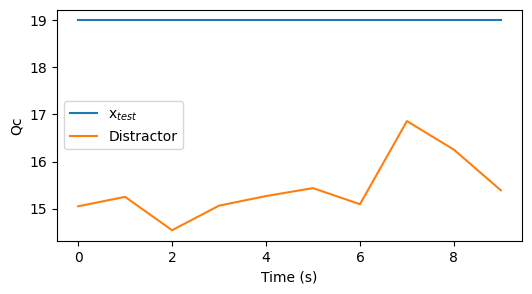

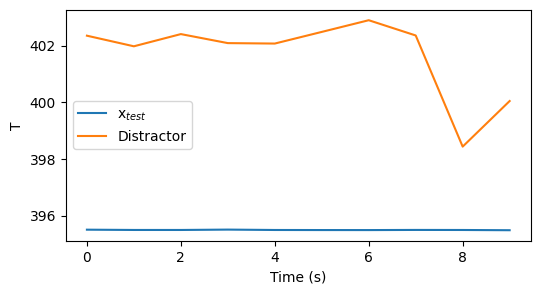

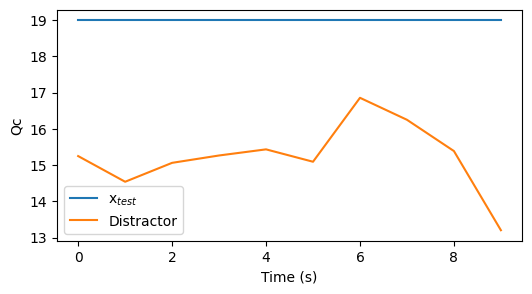

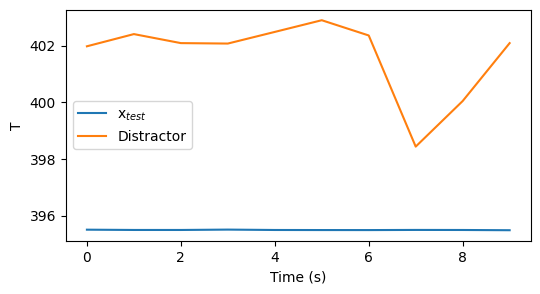

In [28]:
x_test = test_timeseries.loc[['node_9_49'], :, :]
explanation = comte.explain(x_test,to_maximize_class=true_select,savefig=False) 
print('###########') 
print(explanation)
print('###########')